In [6]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from IPython.display import display

In [35]:
# Modules settings
%matplotlib inline
sns.set_theme(style='whitegrid')

In [30]:
with open('./MA_visualize_c_matrix.pickle', 'rb') as file:
    y2_test = pickle.load(file)
    preds2 = pickle.load(file)
    y_multi = pickle.load(file)
    preds_multi = pickle.load(file)

In [275]:
# Prettier confusion matrix
def visualize_c_matrix(y_true,
                       y_pred,
                       title='',
                       categories=[],
                       rotate=False,
                       cmap='',
                       cbar=True,
                       metrics=True,
                       save=True):
    '''
    This function plots a prettier confusion matrix with useful annotations 
       
    and adds a pd.DataFrame with the most common metrics used in classification.
        
    You can use this function with binary or multiclass classification.
    
    The figsize is calculated based on the number of categories.
        
    For both cases:
        * In the main diagonal you get:
            * counts over total of class
            * percentaje over total observations
        * In the rest of the cells you get:
            * counts
            * percentaje over total observations
        * If counts is zero you get an empty cell
           
    In case the function founds binary catergories in your data then a binary
    
    matrix is displayed with the TN, FN, FP, TP tags.
         
    ### Parameters:
    
        y_true -- `array_like`
            True labels.

        y_pred -- `array_like`
            Predictions to compare with true labels.

        title='' -- `str`
            Title to be displayed and used to save file.

        categories=[] -- `list(str)`
            List of names of the classes to be displayed instead of numeric values.

        rotate=False -- `bool`
            Applies a rotation on xticklabels in case they overlap.

        cmap='' -- `Matplotlib colormap name or object, or list of colors` 
            If not provided default is 'Blues'.

        cbar=True -- `bool`
            Whether to draw a colorbar.
            
        metrics=True -- `bool`
            Displays a pd.DataFrame with the most common metrics.

        save=False -- `bool` 
            Saves plot and metrics (if metrics=True) to disk. If title='' default is 'classifier'.
        
    ### Return:
    
        cfm -- `sklearn.metrics.confusion_matrix`
        
        metrics -- `pd.DataFrame`
    '''
                         
    # Generate confusion matrix
    cfm = confusion_matrix(y_true, y_pred)
    
    # Set tipe of classifier: binary or not binary
    if len(cfm)==2:
        base = len(cfm)
        bin_classifier = True
        annot_kws = {"size": 10*base}
        title_fontsize = 12*base
        axis_fontsize = 10*base
        labels_fontsize = 10*base
        plt.figure(figsize=(4.5*base, 4.5*base))
        
    else:
        base = len(cfm)
        bin_classifier = False    
        annot_kws = {"size": 1.5*base}
        title_fontsize = 3.5*base
        axis_fontsize = 2.5*base
        labels_fontsize = 1.5*base
        plt.figure(figsize=(1.75*base, 1.75*base))
    
    # Calculate auxiliar data   
    cfm_rowsum  = np.sum(cfm, axis=1, keepdims=True)
    
    if bin_classifier:
        cfm_percent = cfm / np.sum(cfm).astype(float)
    else:
        cfm_percent = cfm / cfm_rowsum.astype(float)
    
    # Build empty matrix for labels
    labels = np.zeros_like(cfm).astype(str)
    
    # Iterate labels to write correct annot
    nrows, ncols = cfm.shape
    
    for i in range(nrows):
        for j in range(ncols):
            count = cfm[i, j]
            percent = cfm_percent[i, j]
            
            if i == j:
                sum = cfm_rowsum[i]
                labels[i, j] = f'{count} / {int(sum)}\n{percent:.2%}'
            elif count == 0:
                labels[i, j] = ''
            else:
                labels[i, j] = f'{count}\n{percent:.2%}'
    
    if bin_classifier:
        names = ['TN', 'FP', 'FN', 'TP']
        labels = [name + '\n' + label for name, label in zip(names, labels.flatten())]
        labels = np.asarray(labels).reshape(2, 2)
    
    # Set color map
    if cmap == '':
        cmap = 'Blues'
    else:
        pass
        
    # Generate heatmap
    ax = sns.heatmap(cfm,
                     annot=labels,
                     annot_kws=annot_kws,
                     fmt='',
                     square=True,
                     cmap=cmap,
                     cbar=cbar)
        
    # Define categories position
    cat_position = [(i + .5) for i in range(len(labels))]
    
    # Add label rotation        
    if rotate:
        xdegree=50
        plt.yticks(rotation=0)
    else:
        xdegree=0
        plt.yticks(rotation=0)
    
    # Set title label
    if title == '':
        title = 'TRUE LABEL VS. PREDICTED LABEL'
    else:
        pass
    
    ax.set_title(f'{title.upper()}', fontsize=title_fontsize)
    
    # Set axis labels
    ax.set_xlabel('PREDICTED LABEL', fontsize=axis_fontsize)
    ax.xaxis.set_label_position('bottom')
    ax.set_ylabel('TRUE LABEL', fontsize=axis_fontsize)
    ax.yaxis.set_label_position('left')
    
    # Set tick labels
    # Define category names
    if categories != []:
        try:
            categories = [label for label in categories]
            ax.set_xticks(cat_position)
            ax.set_xticklabels(categories, fontsize=labels_fontsize, rotation=xdegree)
            ax.xaxis.tick_bottom()
            
            ax.set_yticklabels(categories, fontsize=labels_fontsize)
            ax.yaxis.tick_left()

        except ValueError:
            print('''Impossible to parse categories with number of classes. Ticklabels set to numeric.''')
            
    # Save plot
    if save:
        name = 'visualizeME_cf_matrix_' + title.lower() + '.png'
        path=os.path.join(name + '.' + 'png')
        plt.savefig(path, format='png', dpi=300)

    # Plot
    plt.show()
        
    # Calculate metrics
    if metrics:
        if bin_classifier:
            metrics_df = pd.DataFrame({title: [f'{accuracy_score(y_true, y_pred):.10f}',
                                            f'{precision_score(y_true, y_pred):.10f}',
                                            f'{recall_score(y_true, y_pred):.10f}',
                                            f'{f1_score(y_true, y_pred):.10f}',
                                            f'{roc_auc_score(y_true, y_pred):.10f}']},
                                   index=[['Accuracy: (TP + TN) / TOTAL',
                                           'Precision: TP / (TP + FP)',
                                           'Recall: TP / (TP + FN)',
                                           'F1: harmonic mean (accuracy, recall)',
                                           'ROC AUC']])
        else:
            report = classification_report(y_true, y_pred)
            report = [line.split(' ') for line in report.splitlines()]

            header = [x.upper() for x in report[0] if x!='']

            index = []
            values = []

            for row in report[1:-5]:
                row = [value for value in row if value!='']
                if row!=[]:
                    index.append(row[0].upper())
                    values.append(row[1:])

            index.append('ACCURACY')
            values.append(['-', '-'] + [x for x in report[-3] if x != ''][-2:])
            index.append('MACRO AVG.')
            values.append([x for x in report[-2] if x != ''][-4:])
            index.append('WEIGHTED AVG.')
            values.append([x for x in report[-1] if x != ''][-4:])

            metrics_df = pd.DataFrame(data=values, columns=header, index=index)

        # Plot metrics
        display(metrics_df)
    
    # Save metrics
    if save:
        name = 'visualizeME_cf_matrix_' + title.lower() + '.csv'
        metrics_df.to_csv(name, header=True)

    return cfm, metrics

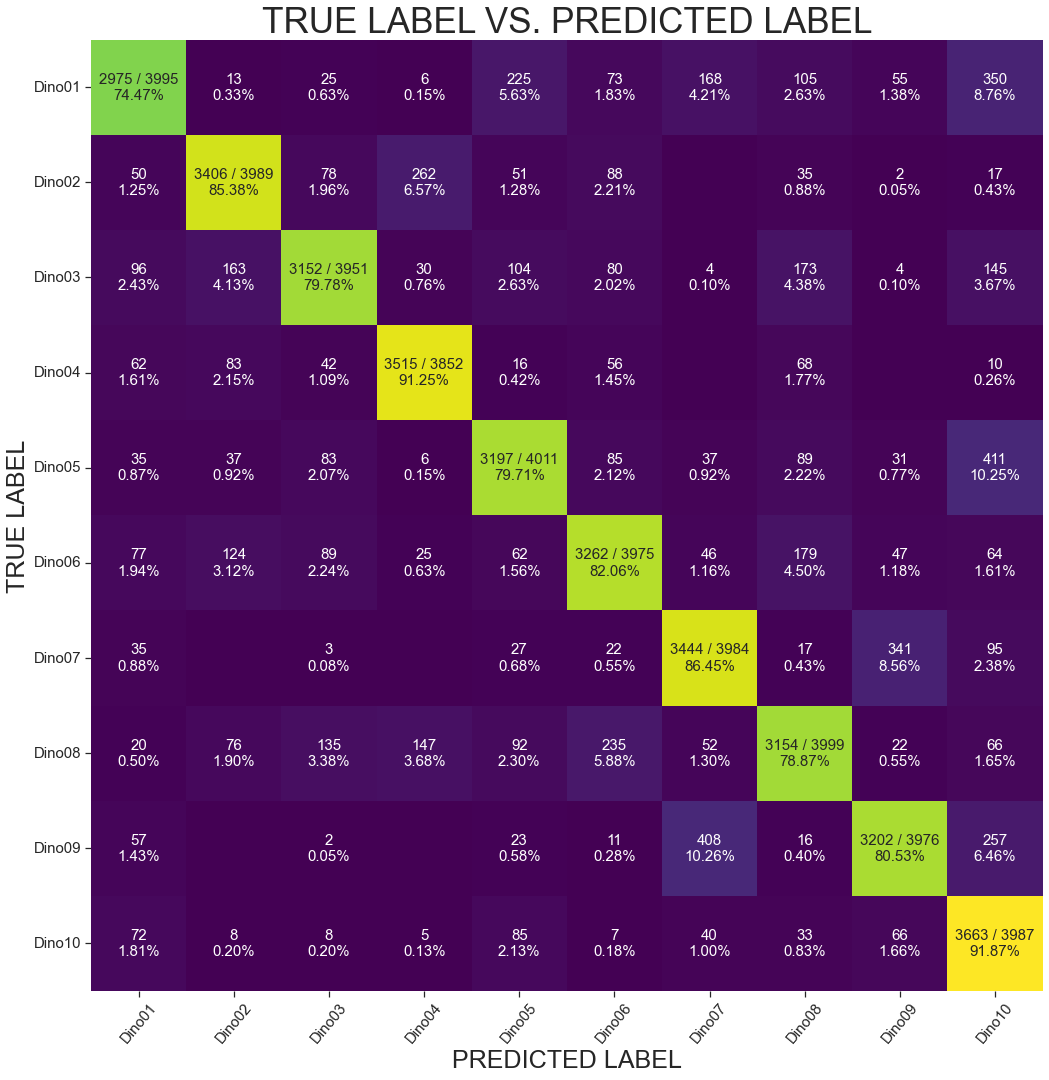

,PRECISION,RECALL,F1-SCORE,SUPPORT
0,0.86,0.74,0.80,3995
1,0.87,0.85,0.86,3989
2,0.87,0.80,0.83,3951
3,0.88,0.91,0.90,3852
4,0.82,0.80,0.81,4011
5,0.83,0.82,0.83,3975
6,0.82,0.86,0.84,3984
7,0.82,0.79,0.80,3999
8,0.85,0.81,0.83,3976
ACCURACY,-,-,0.83,39719


In [264]:
visualize_c_matrix(y_multi,
                   preds_multi,
                   categories=['Dino01', 'Dino02', 'Dino03', 'Dino04', 'Dino05',
                               'Dino06', 'Dino07', 'Dino08', 'Dino09', 'Dino10'], 
                   cmap='viridis',
                   title='',
                   cbar=False,
                   metrics=True,
                   rotate=True,
                   save=False);

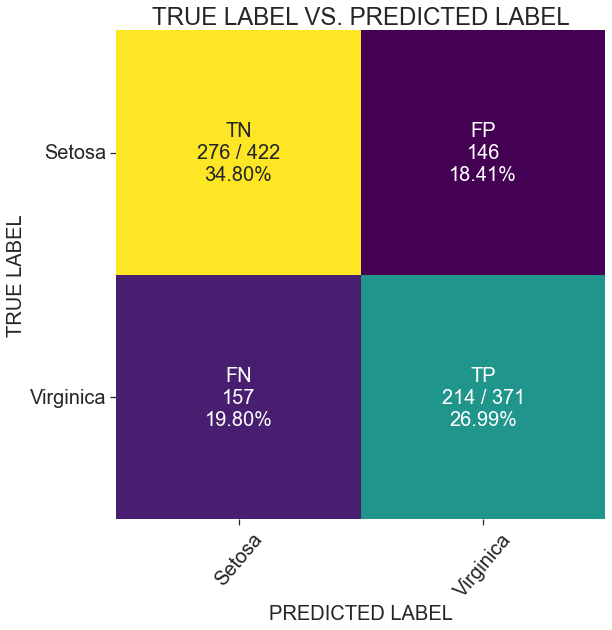

,TRUE LABEL VS. PREDICTED LABEL
Accuracy: (TP + TN) / TOTAL,0.6179066835
Precision: TP / (TP + FP),0.5944444444
Recall: TP / (TP + FN),0.5768194070
"F1: harmonic mean (accuracy, recall)",0.5854993160
ROC AUC,0.6154239215


In [278]:
visualize_c_matrix(y2_test,
                   preds2,
                   title='',
                   categories=['Setosa', 'Virginica'],
                   rotate=True,
                   cmap='viridis',
                   cbar=False,
                   metrics=True,
                   save=True);